# Forward Modeling of an Emission Spectrum using the PreMODIT Cross Section

Update Febrary 7th (2023); November 23rd; Hajime Kawahara

Here, we try to compute a emission spectrum using PreMODIT.
Note that PreMODIT is a beta release. Presumably, we will improve it and release better one in ExoJAX 2.
We try to compute an emission spectrum in which many methane lines exist. This situation mocks a T-type brown dwarf.

In [1]:
from exojax.rt import rtransfer as rt

In [2]:
#ATMOSPHERE                                                                     
NP=100
T0=800.0 #K
Parr, dParr, k=rt.pressure_layer(NP=NP, numpy = True)
Tarr = T0*(Parr)**0.1
Tarr[Tarr<400.0] = 400.0
Tarr[Tarr>1500.0]=1500.0

A T-P profile we assume is here.

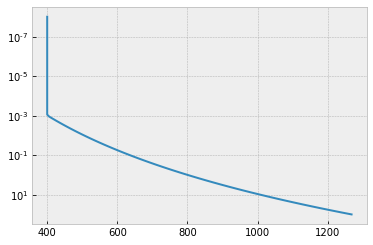

In [3]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.plot(Tarr,Parr)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.show()

We set a wavenumber grid using wavenumber_grid. Specify xsmode="premodit" though it is not mandatory.
MODIT uses FFT, so the (internal) wavenumber grid should be evenly spaced in log. 

In [4]:
from exojax.utils.grids import wavenumber_grid
nus,wav,resolution=wavenumber_grid(16360,16560,10000,unit="AA",xsmode="premodit")

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit


Loading a molecular database of CH4 and CIA (H2-H2)... The point here is gpu_transfer = False. We do not need to send line information to the device.

In [5]:
from exojax.database import api , contdb
mdbCH4=api.MdbExomol('.database/CH4/12C-1H4/YT10to10/',nus,gpu_transfer=False)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

HITRAN exact name= (12C)(1H)4
HITRAN exact name= (12C)(1H)4
Background atmosphere:  H2


/home/kawahara/exojax/src/exojax/utils/molname.py:49: UserWarning: No isotope number identified.
  warnings.warn("No isotope number identified.",UserWarning)
/home/kawahara/exojax/src/exojax/utils/molname.py:49: UserWarning: No isotope number identified.
  warnings.warn("No isotope number identified.",UserWarning)
/home/kawahara/exojax/src/exojax/spec/molinfo.py:28: UserWarning: exact molecule name is not Exomol nor HITRAN form.
  warnings.warn("exact molecule name is not Exomol nor HITRAN form.")
/home/kawahara/exojax/src/exojax/spec/molinfo.py:29: UserWarning: No molmass available
  warnings.warn("No molmass available", UserWarning)


Reading .database/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10__06000-06100.trans.bz2
Reading .database/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10__06100-06200.trans.bz2
.broad is used.
Broadening code level= a1
default broadening parameters are used for  23  J lower states in  40  states
H2-H2


We have 80.5 million lines

In [6]:
len(mdbCH4.A)

80505310

In fact, this number is too large for MODIT.

In [7]:
molmassCH4=mdbCH4.molmass

OpaPremodit is a opacity calculator class for PreMODIT. You need to define diffmode (0, 1, or, 2) and auto_trange, in which the precision of the line strenght is within 1%. 

In [8]:
from exojax.opacity.opacalc import OpaPremodit
diffmode = 0
opa = OpaPremodit(mdb=mdbCH4,
                      nu_grid=nus,
                      diffmode=diffmode,
                      auto_trange=[400.0, 1500.0])
    


OpaPremodit: params automatically set.
Robust range: 397.77407283130566 - 1689.7679243628259 K
Tref changed: 296.0K->1153.6267095763965K


uniqidx: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


Premodit: Twt= 461.3329793405918 K Tref= 1153.6267095763965 K


opa.xsmatrix can compute a cross section matrix for given temperature and pressure arrays.

In [9]:
xsm = opa.xsmatrix(Tarr, Parr)    

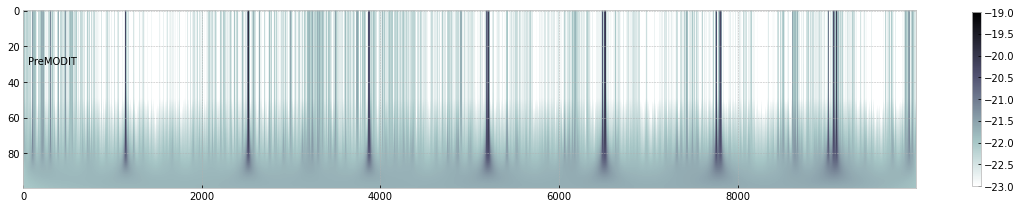

In [10]:
import numpy as np
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(111)
c=plt.imshow(np.log10(xsm),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"PreMODIT")
ax.set_aspect(0.2/ax.get_data_ratio())
plt.show()

This negative value is very small. For instance, jnp.abs can remove it.

In [12]:
import jax.numpy as jnp
xsm=jnp.abs(xsm)

computing delta tau for CH4

In [13]:
from exojax.rt.rtransfer import dtauM
import jax.numpy as jnp
Rp=0.88
Mp=33.2
g=2478.57730044555*Mp/Rp**2 #gravity cm/s2
MMR=0.0059 #mass mixing ratio
dtaum=dtauM(dParr,xsm,MMR*np.ones_like(Tarr),molmassCH4,g)

computing delta tau for CIA

In [15]:
from exojax.rt.rtransfer import dtauCIA
from exojax.database import molinfo 
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass_isotope("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

The total delta tau is a summation of them

In [16]:
dtau=dtaum+dtaucH2H2

you can plot a contribution function using exojax.plot.atmplot 

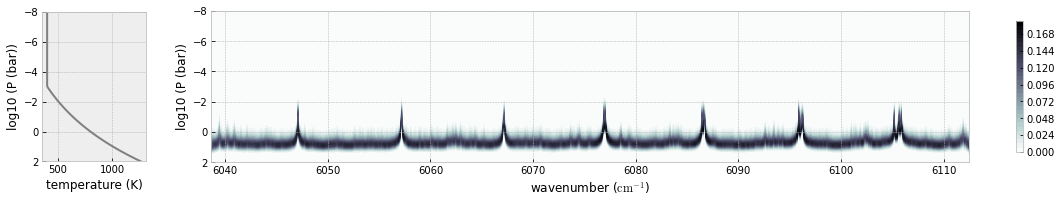

In [17]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

radiative transfering...

In [18]:
from exojax.rt import planck
from exojax.rt.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)

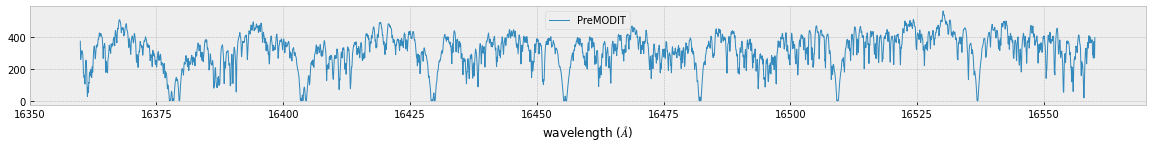

In [19]:
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(211)
plt.plot(wav[::-1],F0,lw=1,label="PreMODIT")
plt.legend()
plt.xlabel("wavelength ($\AA$)")
plt.savefig("ch4.png")

PreMODIT uses ESLOG as the wavenunmber grid. We can directly apply the response to the raw spectrum.

In [20]:
#response and rotation settings 
from exojax.postproc.response import ipgauss_sampling
from exojax.postproc.spin_rotation import convolve_rigid_rotation
from exojax.utils.grids import velocity_grid
vsini_max = 100.0
vr_array = velocity_grid(resolution, vsini_max)


from exojax.utils.constants import c
import jax.numpy as jnp

wavd=jnp.linspace(16360,16560,1500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

Rinst=100000. #spectral resolution of the spectrograph
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*Rinst) #IP sigma (STD of Gaussian)
Frot = convolve_rigid_rotation(F0, vr_array, vsini, u1, u2)
F = ipgauss_sampling(nusd, nus, Frot, beta, RV)


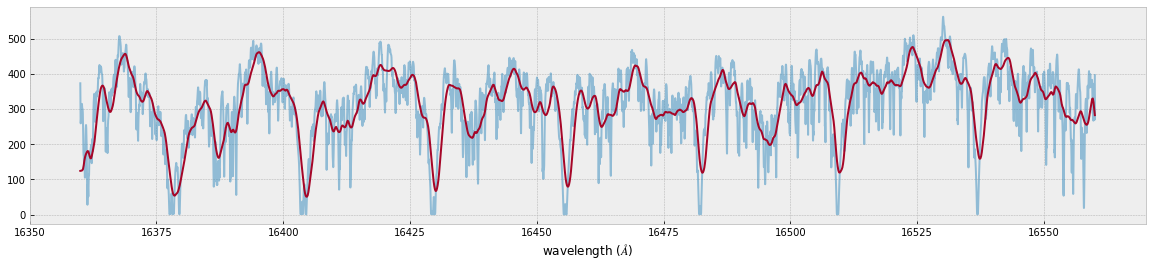

In [21]:
fig=plt.figure(figsize=(20,4))
plt.plot(wav[::-1],F0,alpha=0.5)
plt.plot(wavd[::-1],F)
plt.xlabel("wavelength ($\AA$)")
plt.savefig("moditCH4.png")

Let's save the spectrum for the retrieval.

In [22]:
np.savetxt("spectrum_ch4_high.txt",np.array([wavd,F]).T,delimiter=",")